###### source & script : https://www.kaggle.com/drgilermo/dynamics-of-new-york-city-animation

k평균 군집 으로 군집화한 후 분석
1. 데이터가 지도처럼 그래프로 표시됨
2. animation : html 을 사용한 gif 형태의 그래프(ImageMagick 설치 필요)
<br></br><br></br>
![1](img/kaggle10/animation.gif)
<br></br><br></br>

--- 

###### source & script : https://www.kaggle.com/aiswaryaramachandran/eda-baseline-model-0-40-rmse

1. 승차시간을 로그스케일 취한 결과 정규분포에 근사하게 나온 것이 신기했음
2. Folium 지도라이브러리를 이용한 시각화가 굉장히 유용하다.

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser
import io
import base64
from IPython.display import HTML
from imblearn.under_sampling import RandomUnderSampler
from subprocess import check_output
print(os.listdir('taxi_data'))

['sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
df = pd.read_csv('taxi_data/train.csv')

In [3]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
df = df[(df.pickup_longitude > xlim[0]) & (df.pickup_longitude < xlim[1])]
df = df[(df.dropoff_longitude > xlim[0]) & (df.dropoff_longitude < xlim[1])]
df = df[(df.pickup_latitude > ylim[0]) & (df.pickup_latitude < ylim[1])]
df = df[(df.dropoff_latitude > ylim[0]) & (df.dropoff_latitude < ylim[1])]

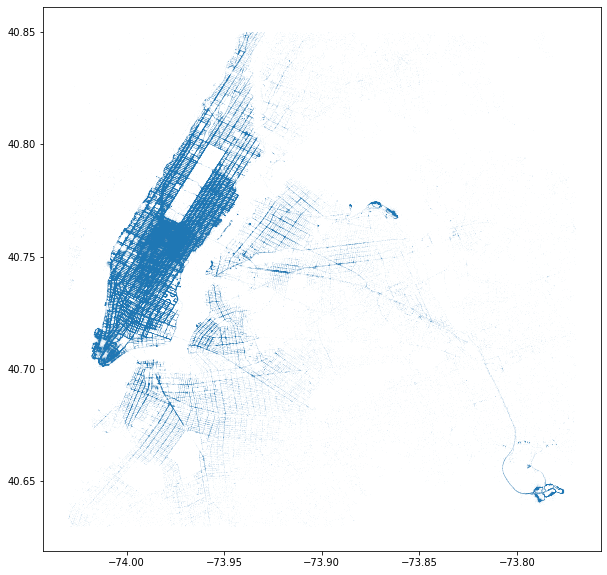

In [5]:
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)
plt.figure(figsize=(10, 10))
plt.plot(longitude, latitude, '.', alpha=0.4, markersize=0.05)
plt.show()

In [6]:
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

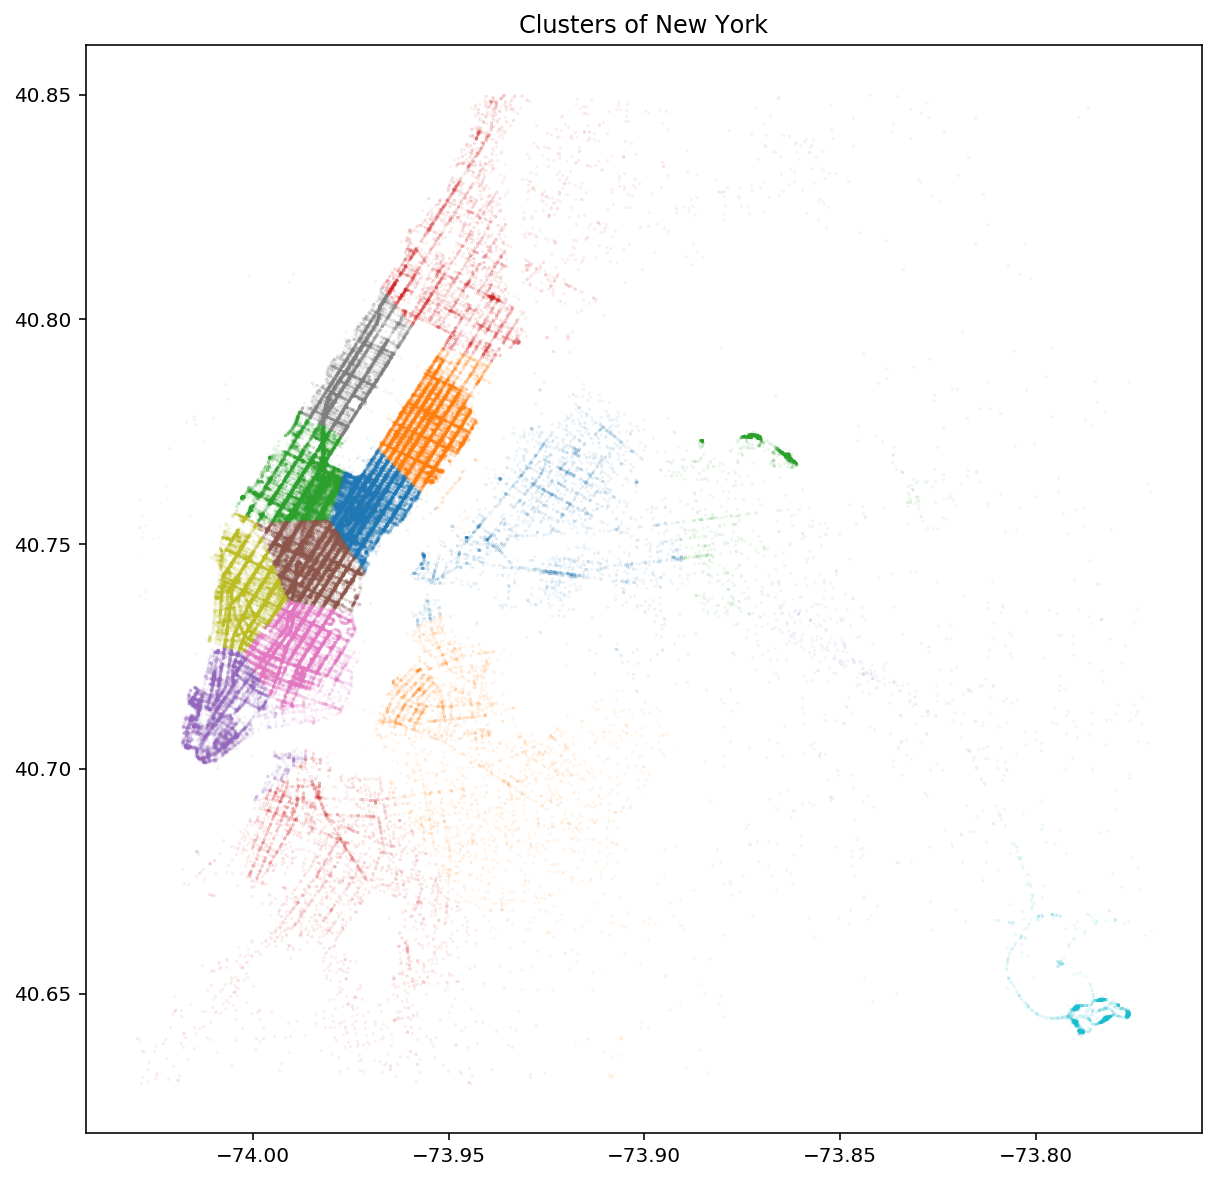

In [7]:
kmeans = KMeans(n_clusters=15, random_state=2, n_init=10).fit(loc_df)
loc_df['label'] = kmeans.labels_

loc_df = loc_df.sample(200000)
plt.figure(figsize=(10, 10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],
             loc_df.latitude[loc_df.label == label],
             '.',
             alpha=0.3,
             markersize=0.3)

plt.title('Clusters of New York')
plt.show()

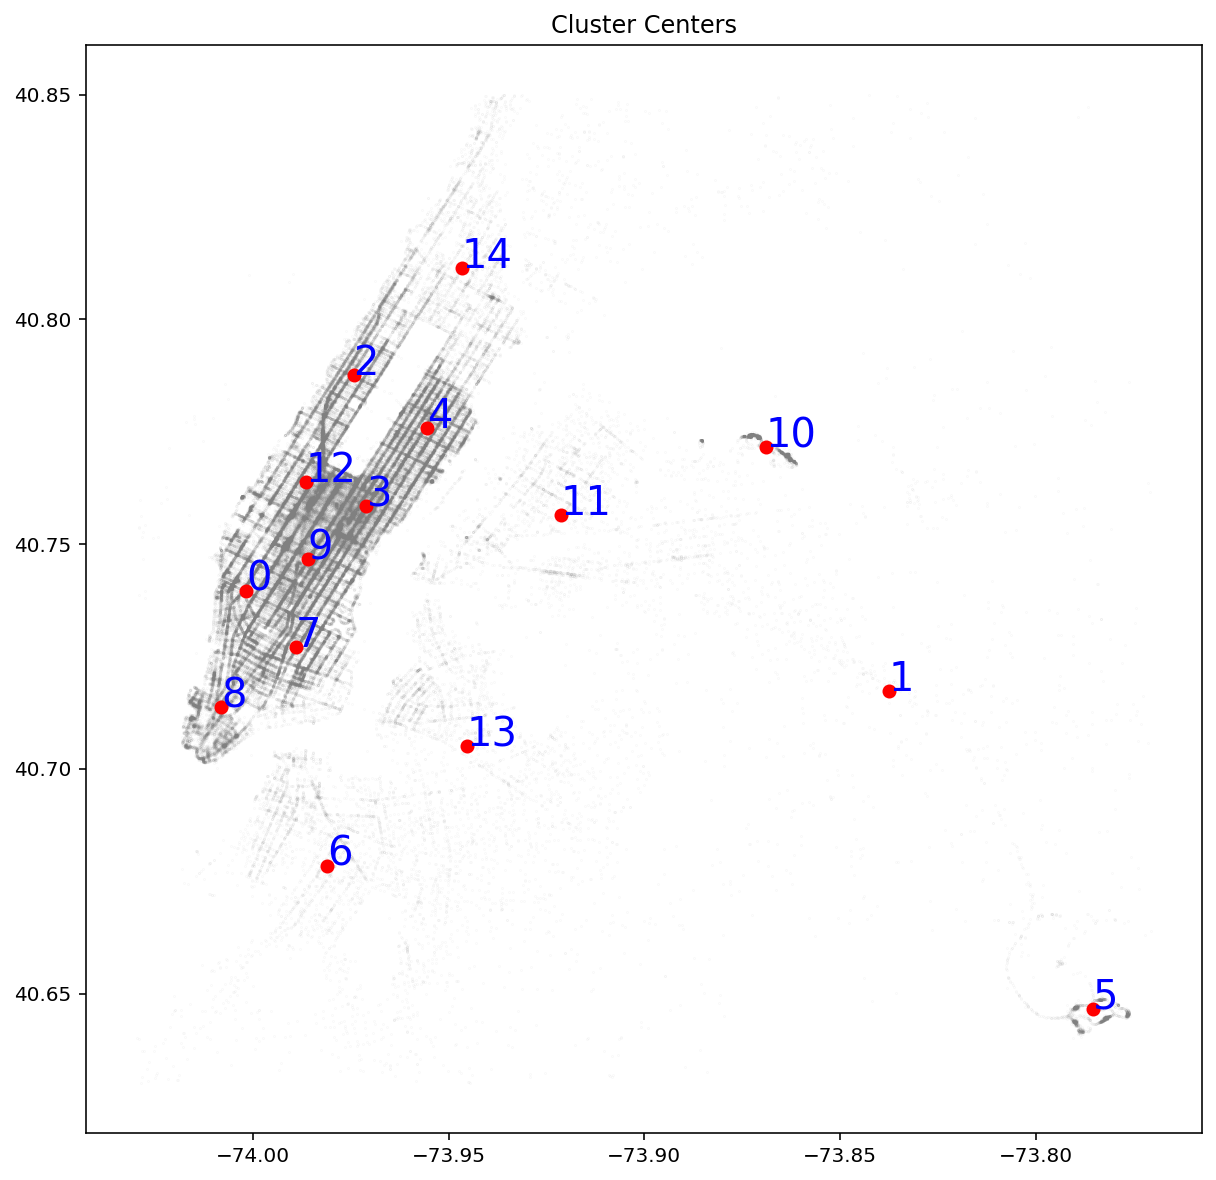

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label],
            loc_df.latitude[loc_df.label == label],
            '.',
            alpha=0.4,
            markersize=0.1,
            color='gray')
    ax.plot(kmeans.cluster_centers_[label, 0],
            kmeans.cluster_centers_[label, 1],
            'o',
            color='r')
    ax.annotate(
        label,
        (kmeans.cluster_centers_[label, 0], kmeans.cluster_centers_[label, 1]),
        color='b',
        fontsize=20)
ax.set_title('Cluster Centers')
plt.show()

In [9]:
df['pickup_cluster'] = kmeans.predict(
    df[['pickup_longitude', 'pickup_latitude']])
df['dropoff_cluster'] = kmeans.predict(
    df[['dropoff_longitude', 'dropoff_latitude']])
df['pickup_hour'] = df.pickup_datetime.apply(lambda x: parser.parse(x).hour)

In [10]:
clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:, 0]
clusters['y'] = kmeans.cluster_centers_[:, 1]
clusters['label'] = range(len(clusters))

In [11]:
loc_df = loc_df.sample(5000)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))


def animate(hour):
    ax.clear()
    ax.set_title('Absolute Traffic - Hour ' + str(int(hour)) + ':00')
    plt.figure(figsize=(10, 10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],
                loc_df.latitude[loc_df.label == label],
                '.',
                alpha=1,
                markersize=2,
                color='gray')
        ax.plot(kmeans.cluster_centers_[label, 0],
                kmeans.cluster_centers_[label, 1],
                'o',
                color='r')

    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label)
                                  & (df.dropoff_cluster == dest_label) &
                                  (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[
                0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[
                0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides, len(df))
            arr = Arrow(clusters.x[clusters.label == label].values,
                        clusters.y[clusters.label == label].values,
                        -dist_x,
                        -dist_y,
                        edgecolor='white',
                        width=15 * pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')


ani = animation.FuncAnimation(fig,
                              animate,
                              sorted(df.pickup_hour.unique()),
                              interval=1000)
plt.close()
ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(
    encoded.decode('ascii')))

In [15]:
neighborhood = {
    -74.0019368351: 'Chelsea',
    -73.837549761: 'Queens',
    -73.7854240738: 'JFK',
    -73.9810421975: 'Midtown-North-West',
    -73.9862336241: 'East Village',
    -73.971273324: 'Midtown-North-East',
    -73.9866739677: 'Brooklyn-parkslope',
    -73.8690098118: 'LaGuardia',
    -73.9890572967: 'Midtown',
    -74.0081765545: 'Downtown',
    -73.9213024854: 'Queens-Astoria',
    -73.9470256923: 'Harlem',
    -73.9555565018: 'Uppe East Side',
    -73.9453487097: 'Brooklyn-Williamsburgt',
    -73.9745967889: 'Upper West Side'
}

In [29]:
rides_df = pd.DataFrame(columns=neighborhood.values())
rides_df['name'] = neighborhood.values()

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(
    np.array(list(neighborhood.keys())).reshape(-1, 1),
    list(neighborhood.values()))

KNeighborsClassifier(n_neighbors=1)

In [30]:
df['pickup_neighborhood'] = neigh.predict(
    df.pickup_longitude.values.reshape(-1, 1))
df['dropoff_neighborhood'] = neigh.predict(
    df.dropoff_longitude.values.reshape(-1, 1))

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[
        (df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col)]))

In [34]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

trace = go.Heatmap(z=np.array(rides_df.values),
                   x=rides_df.columns[:-1],
                   y=rides_df.columns)
layout = dict(title=' <b>Neighborhoods Interaction</b>',
              titlefont=dict(size=30, color=('rgb(100,100,100)')),
              margin=dict(t=100, r=100, b=100, l=150),
              yaxis=dict(title=' <b> From </b>'),
              xaxis=dict(title='<b> To </b>'))
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

In [35]:
rides_df.index = rides_df.name
rides_df = rides_df.drop('name', axis=1)

Text(0.5, 1.0, 'Inbound and Outbound rides for each cluster')

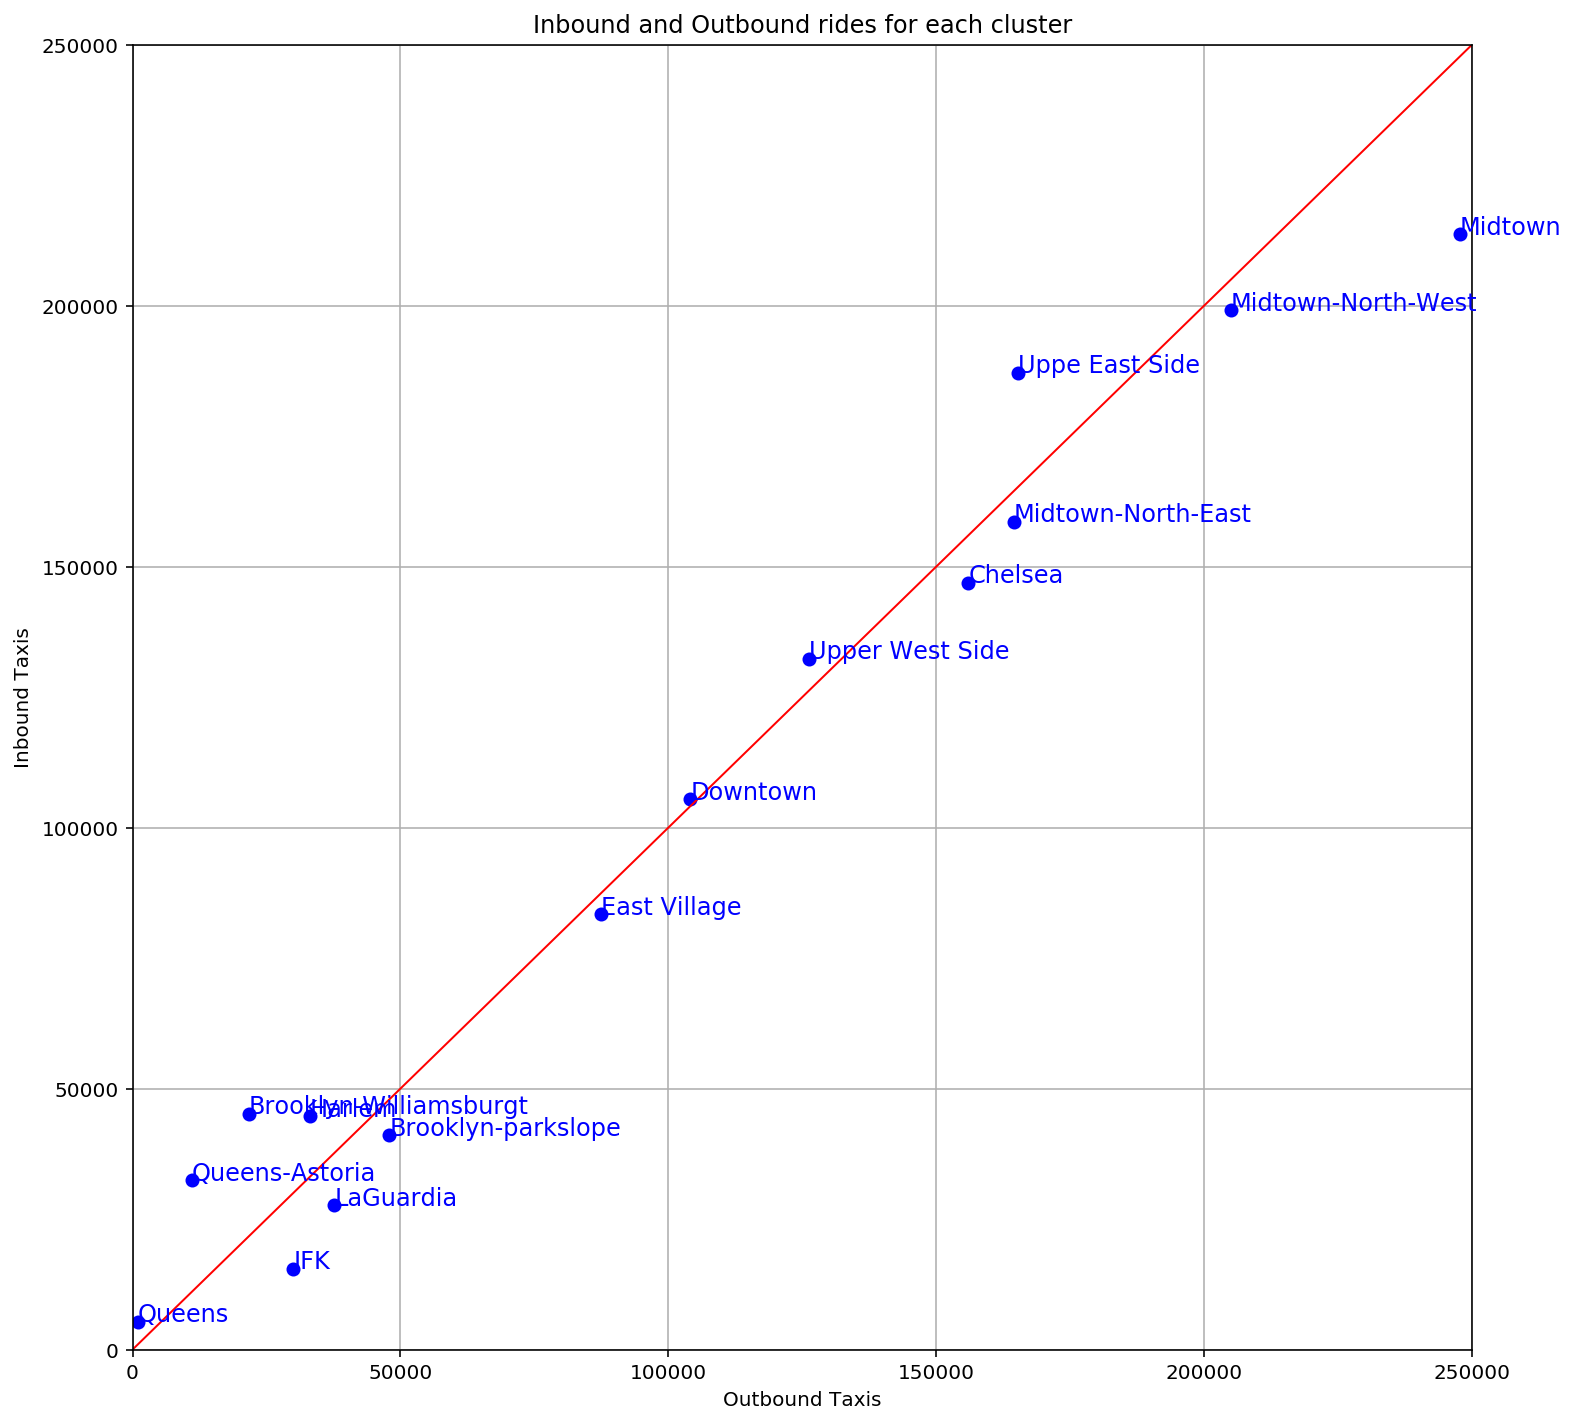

In [36]:
fig, ax = plt.subplots(figsize=(12, 12))
for i in range(len(rides_df)):
    ax.plot(rides_df.sum(axis=1)[i], rides_df.sum(axis=0)[i], 'o', color='b')
    ax.annotate(rides_df.index.tolist()[i],
                (rides_df.sum(axis=1)[i], rides_df.sum(axis=0)[i]),
                color='b',
                fontsize=12)

ax.plot([0, 250000], [0, 250000], color='r', linewidth=1)
ax.grid('off')
ax.set_xlim([0, 250000])
ax.set_ylim([0, 250000])
ax.set_xlabel('Outbound Taxis')
ax.set_ylabel('Inbound Taxis')
ax.set_title('Inbound and Outbound rides for each cluster')

In [37]:
df['pickup_month'] = df.pickup_datetime.apply(lambda x: parser.parse(x).month)

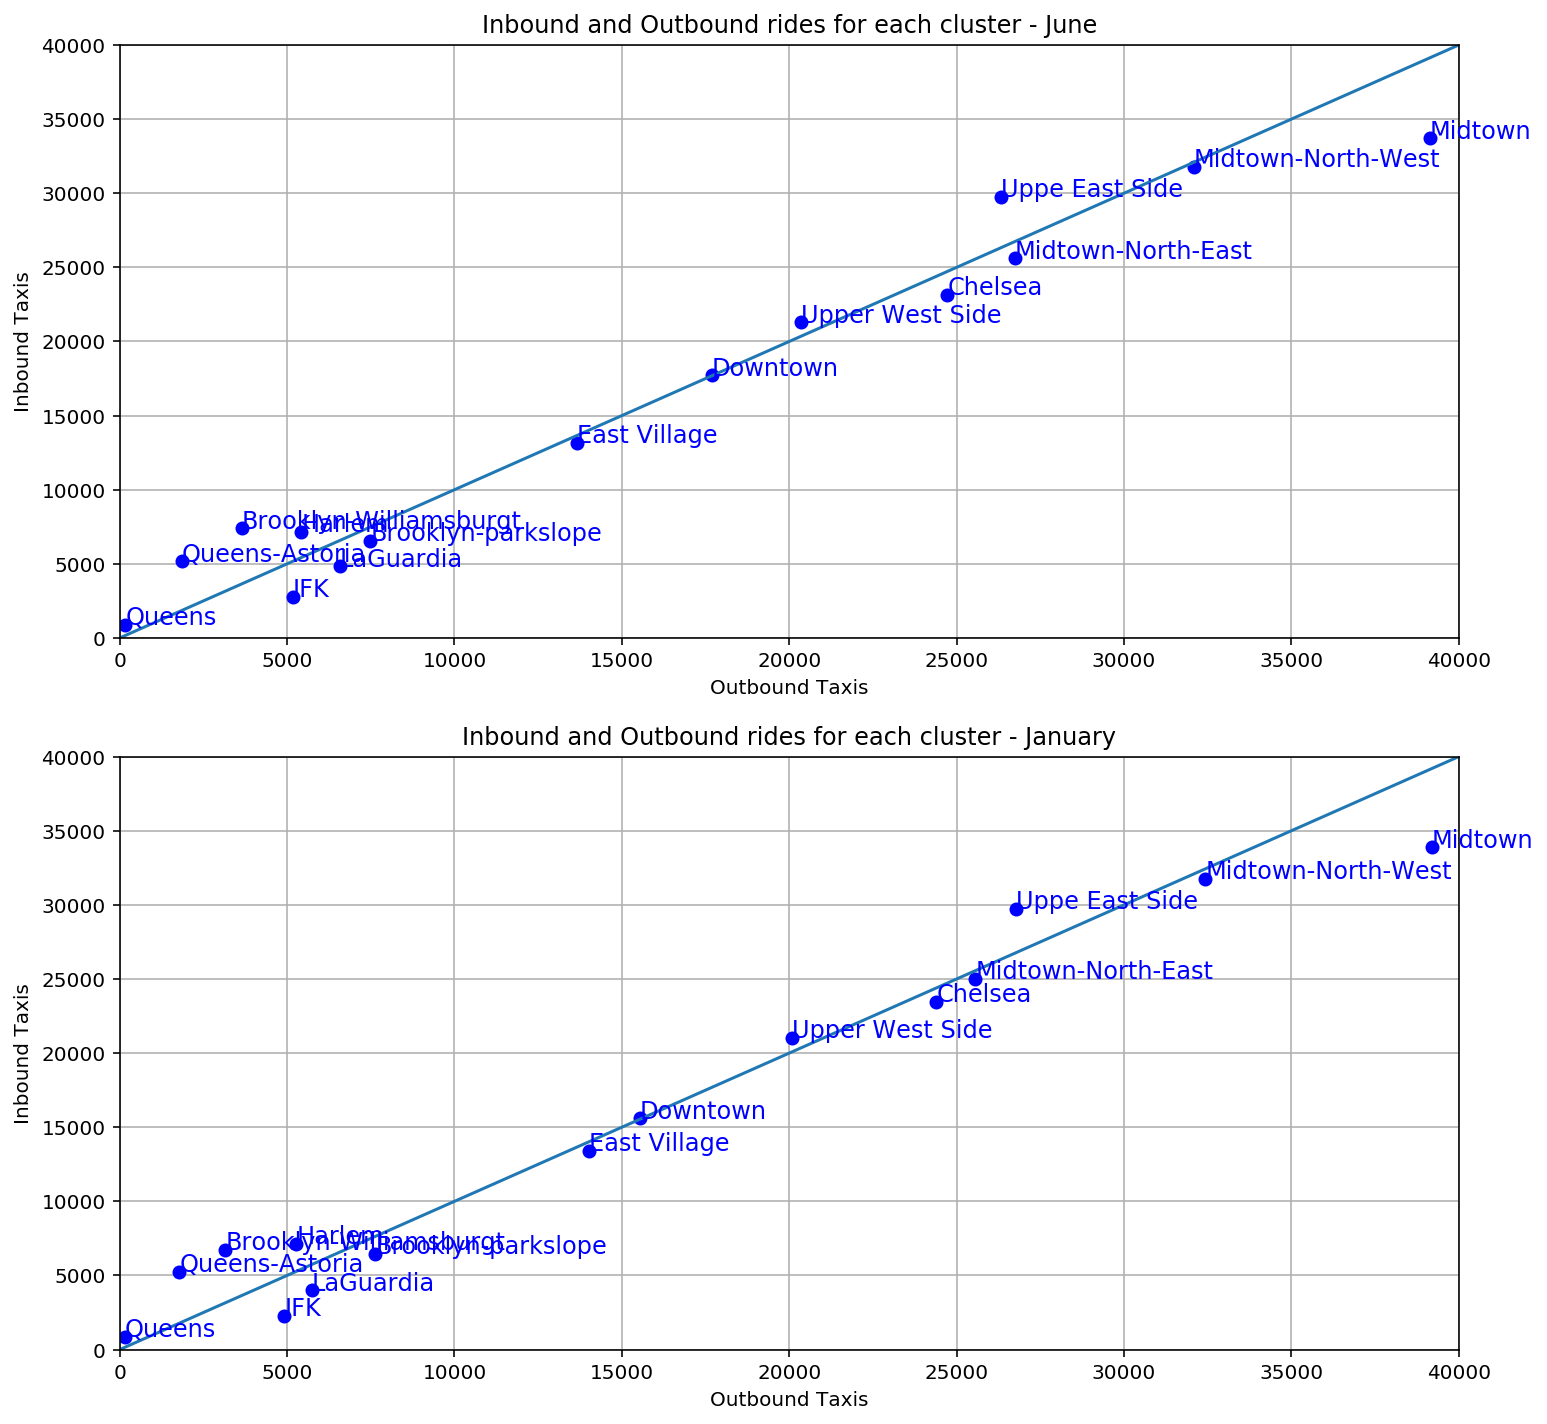

In [38]:
fig, ax = plt.subplots(2, figsize=(12, 12))

rides_df = pd.DataFrame(columns=neighborhood.values())
rides_df['name'] = neighborhood.values()
rides_df.index = rides_df.name

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[
        (df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) &
        (df.pickup_month == 6)]))
for i in range(len(rides_df)):
    ax[0].plot(rides_df.sum(axis=1)[i],
               rides_df.sum(axis=0)[i],
               'o',
               color='b')
    ax[0].annotate(rides_df.index.tolist()[i],
                   (rides_df.sum(axis=1)[i], rides_df.sum(axis=0)[i]),
                   color='b',
                   fontsize=12)

ax[0].grid('off')
ax[0].set_xlabel('Outbound Taxis')
ax[0].set_ylabel('Inbound Taxis')
ax[0].set_title('Inbound and Outbound rides for each cluster - June')
ax[0].set_xlim([0, 40000])
ax[0].set_ylim([0, 40000])
ax[0].plot([0, 40000], [0, 40000])

for col in rides_df.columns[:-1]:
    rides_df[col] = rides_df.name.apply(lambda x: len(df[
        (df.pickup_neighborhood == x) & (df.dropoff_neighborhood == col) &
        (df.pickup_month == 1)]))
rides_df = rides_df.drop('name', axis=1)
for i in range(len(rides_df)):
    ax[1].plot(rides_df.sum(axis=1)[i],
               rides_df.sum(axis=0)[i],
               'o',
               color='b')
    ax[1].annotate(rides_df.index.tolist()[i],
                   (rides_df.sum(axis=1)[i], rides_df.sum(axis=0)[i]),
                   color='b',
                   fontsize=12)

ax[1].grid('off')
ax[1].set_xlabel('Outbound Taxis')
ax[1].set_ylabel('Inbound Taxis')
ax[1].set_title('Inbound and Outbound rides for each cluster - January')
ax[1].set_xlim([0, 40000])
ax[1].set_ylim([0, 40000])
ax[1].plot([0, 40000], [0, 40000])

###### source & script : https://www.kaggle.com/aiswaryaramachandran/eda-baseline-model-0-40-rmse

---

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle

In [43]:
train = pd.read_csv("taxi_data/train.csv")
test = pd.read_csv("taxi_data/test.csv")
test.shape

(625134, 9)

In [44]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'],
                                          format='%Y-%m-%d %H:%M:%S')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'],
                                           format='%Y-%m-%d %H:%M:%S')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [45]:
train[pd.isnull(train)].sum()

id                    0.0
vendor_id             0.0
pickup_datetime       0.0
dropoff_datetime      0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
dtype: float64

In [46]:
print("Min pickup time:", min(train['pickup_datetime']))
print("Max pickup time:", max(train['pickup_datetime']))

Min pickup time: 2016-01-01 00:00:17
Max pickup time: 2016-06-30 23:59:39


In [47]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].apply(lambda x: x.day)
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x: x.hour)
train['pickup_day_of_week'] = train['pickup_datetime'].apply(
    lambda x: calendar.day_name[x.weekday()])
train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day'] = train['dropoff_datetime'].apply(lambda x: x.day)
train['dropoff_hour'] = train['dropoff_datetime'].apply(lambda x: x.hour)
train['dropoff_day_of_week'] = train['dropoff_datetime'].apply(
    lambda x: calendar.day_name[x.weekday()])

In [48]:
train['pickup_latitude_round3'] = train['pickup_latitude'].apply(
    lambda x: round(x, 3))
train['pickup_longitude_round3'] = train['pickup_longitude'].apply(
    lambda x: round(x, 3))
train['dropoff_latitude_round3'] = train['dropoff_latitude'].apply(
    lambda x: round(x, 3))
train['dropoff_longitude_round3'] = train['dropoff_longitude'].apply(
    lambda x: round(x, 3))

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973


In [49]:
def calculateDistance(row):
    R = 6373.0  # approximate radius of earth in km
    pickup_lat = radians(row['pickup_latitude'])
    pickup_lon = radians(row['pickup_longitude'])
    dropoff_lat = radians(row['dropoff_latitude'])
    dropoff_lon = radians(row['dropoff_longitude'])
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    a = sin(
        dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [50]:
train['trip_distance'] = train.apply(lambda row: calculateDistance(row),
                                     axis=1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962


In [51]:
train['trip_duration_in_hour'] = train['trip_duration'].apply(
    lambda x: x / 3600)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833


Text(0.5, 0, 'Trip Duration (in hour)')

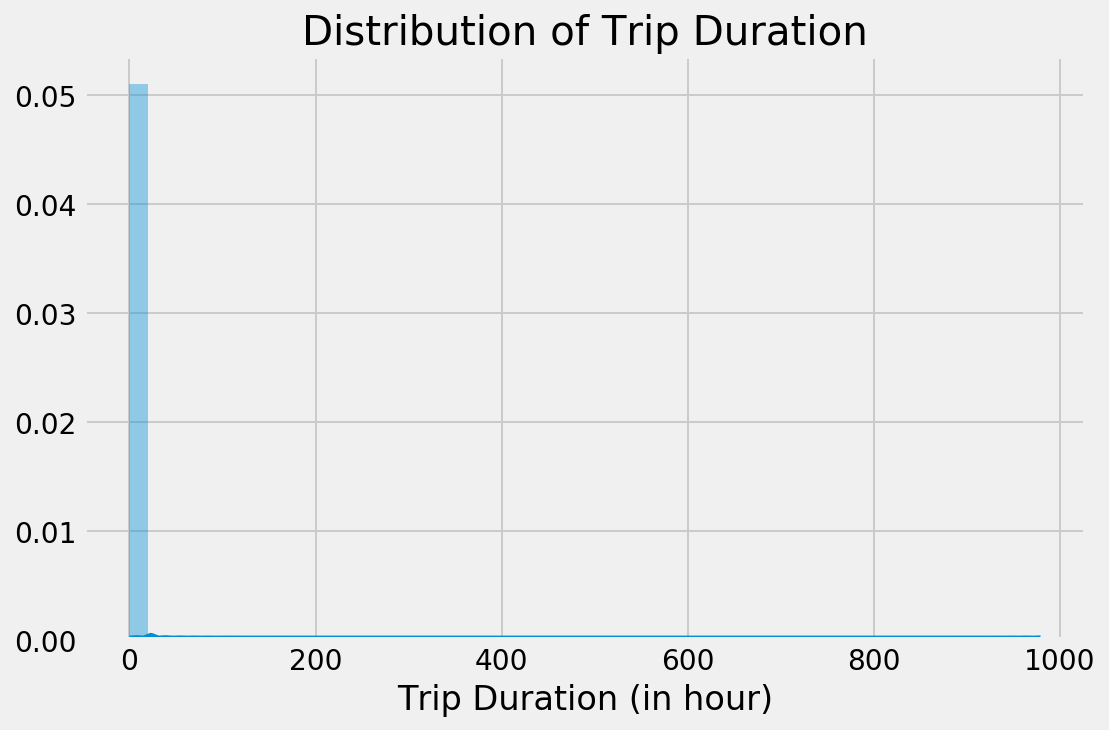

In [52]:
plt.figure(figsize=(8, 5))
sns.distplot(
    train['trip_duration_in_hour']).set_title("Distribution of Trip Duration")
plt.xlabel("Trip Duration (in hour)")

In [53]:
outlier_trip_duration = train.loc[train['trip_duration_in_hour'] > 24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


Text(0.5, 1.0, 'Distribution of trip duration (sec) in Log Scale')

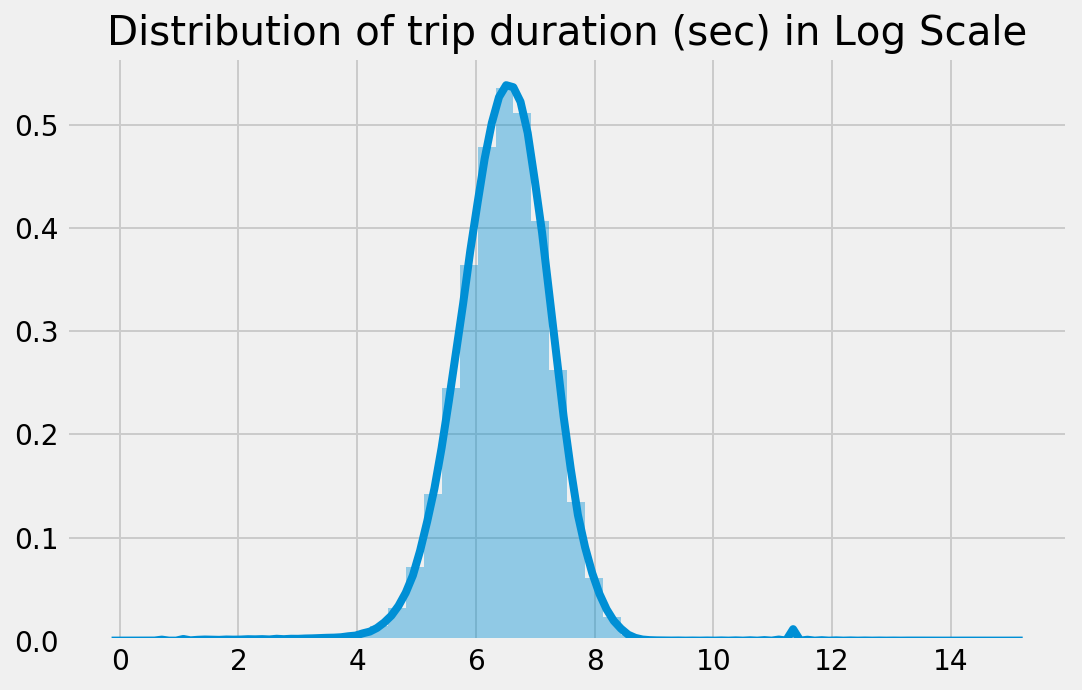

In [55]:
plt.figure(figsize=(8, 5))
sns.distplot(np.log(
    train['trip_duration'].values)).set_title("Distribution of Trip Duration")
plt.title("Distribution of trip duration (sec) in Log Scale")

In [56]:
pickup = train.groupby([
    'pickup_latitude_round3', 'pickup_longitude_round3'
])['id'].count().reset_index().rename(columns={'id': 'Num_Trips'})

(-74.03, -73.75)

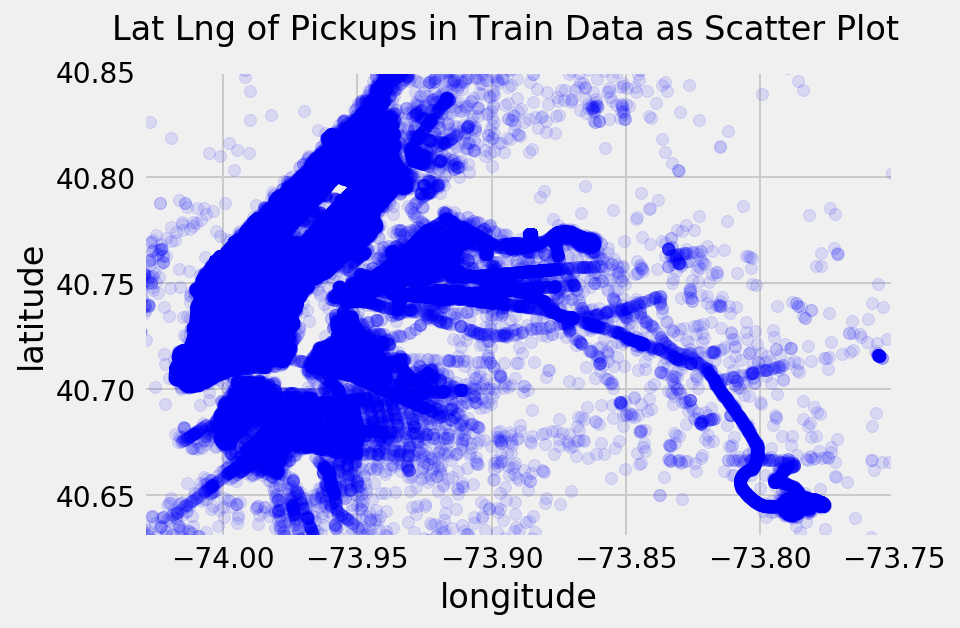

In [58]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'],
           train['pickup_latitude'],
           color='blue',
           label='train',
           alpha=0.1)

fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [59]:
drop = train.groupby([
    'dropoff_latitude_round3', 'dropoff_longitude_round3'
])['id'].count().reset_index().rename(columns={'id': 'Num_Trips'})

In [61]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'
                        ])['trip_duration'].mean().reset_index().rename(
                            columns={'trip_duration': 'Avg_Trip_duration'})

In [62]:
pickup_map = folium.Map(
    location=[40.730610, -73.935242],
    zoom_start=10,
)

hm_wide = HeatMap(list(
    zip(pickup.pickup_latitude_round3.values,
        pickup.pickup_longitude_round3.values,
        pickup.Avg_Trip_duration.values)),
                  min_opacity=0.2,
                  radius=7,
                  blur=15,
                  max_zoom=1)
pickup_map.add_child(hm_wide)
pickup_map

Text(0.5, 1.0, 'Pickup Hours Distribution')

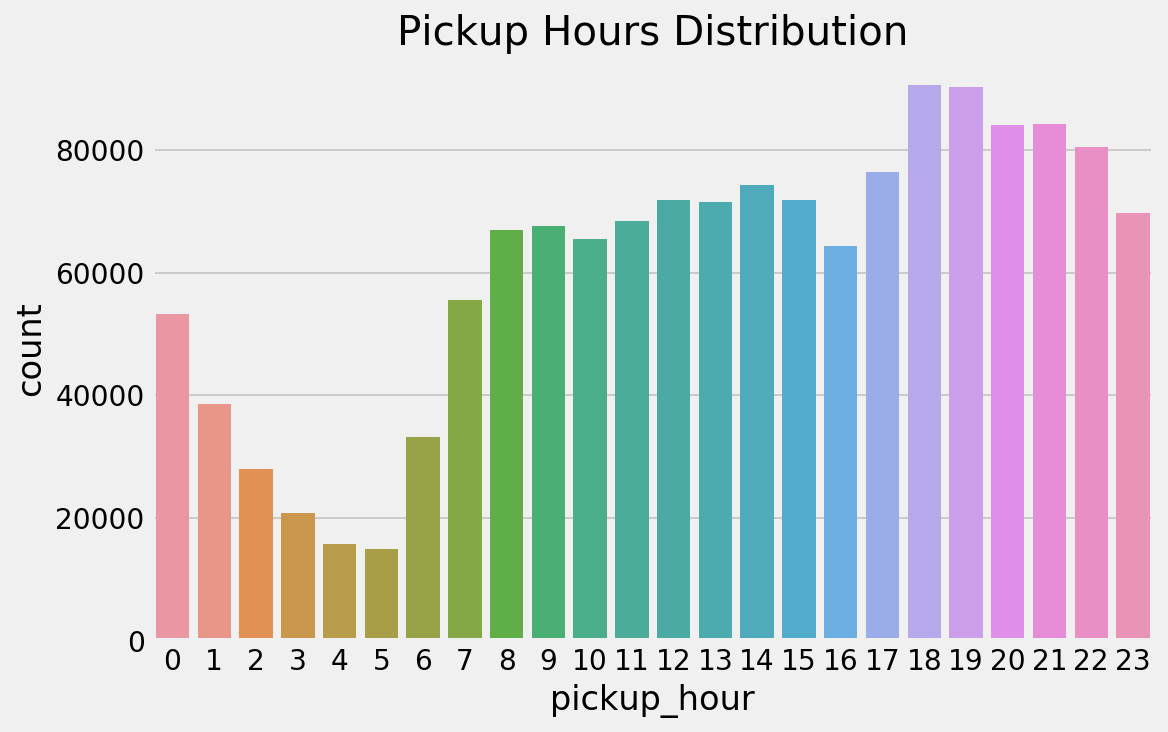

In [63]:
plt.figure(figsize=(8, 5))
sns.countplot(x=train['pickup_hour']).set_title("Pickup Hours Distribution")

Text(0.5, 1.0, 'Dropoff Hours Distribution')

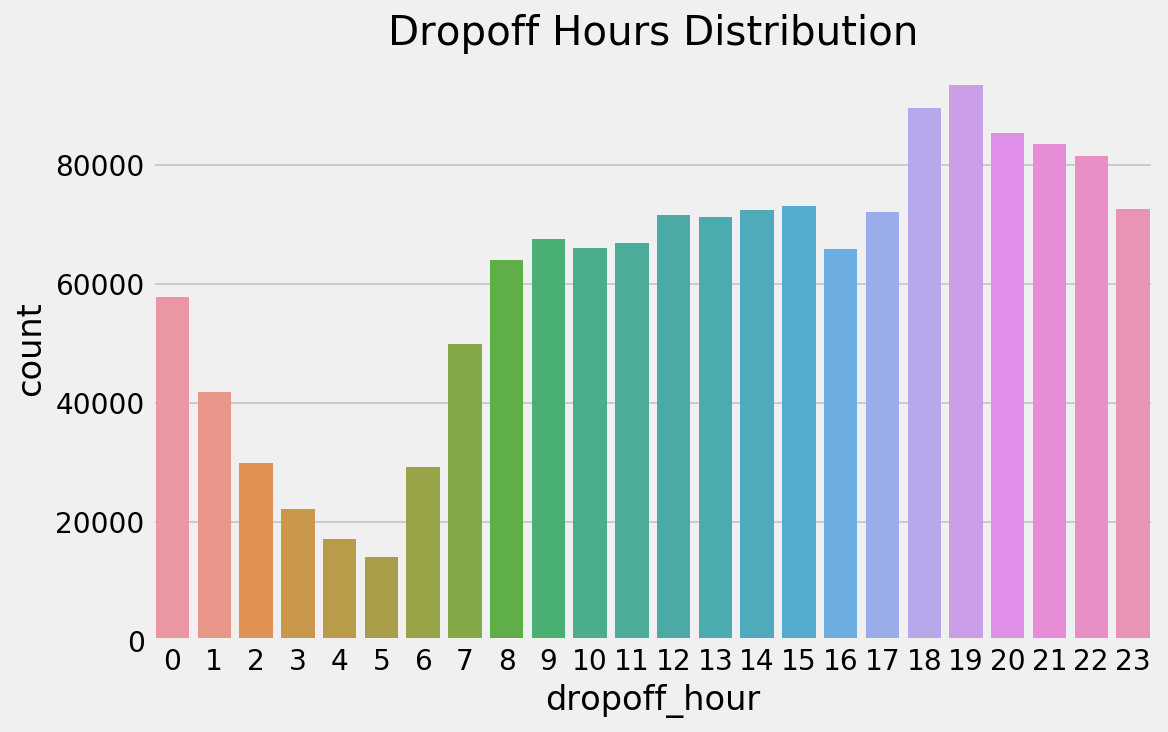

In [64]:
plt.figure(figsize=(8, 5))
sns.countplot(x=train['dropoff_hour']).set_title("Dropoff Hours Distribution")

Text(0.5, 1.0, 'Distribution of Pickups over time')

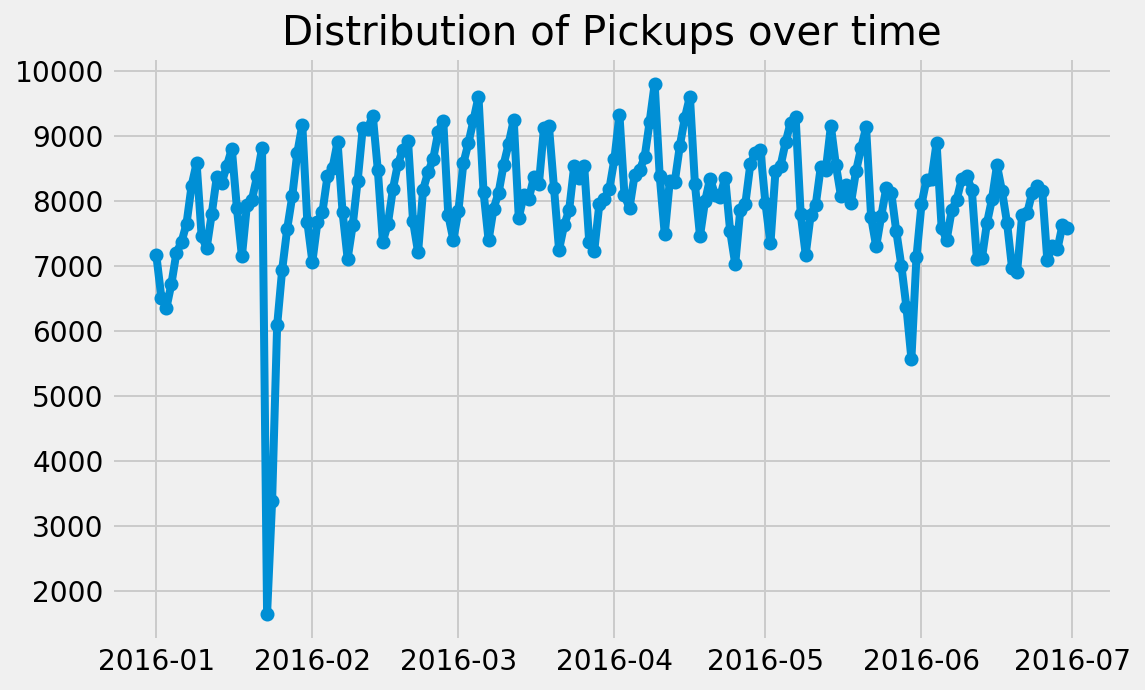

In [65]:
plt.figure(figsize=(8, 5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')

plt.title("Distribution of Pickups over time")

Text(0.5, 0, 'Trip Distance (log)')

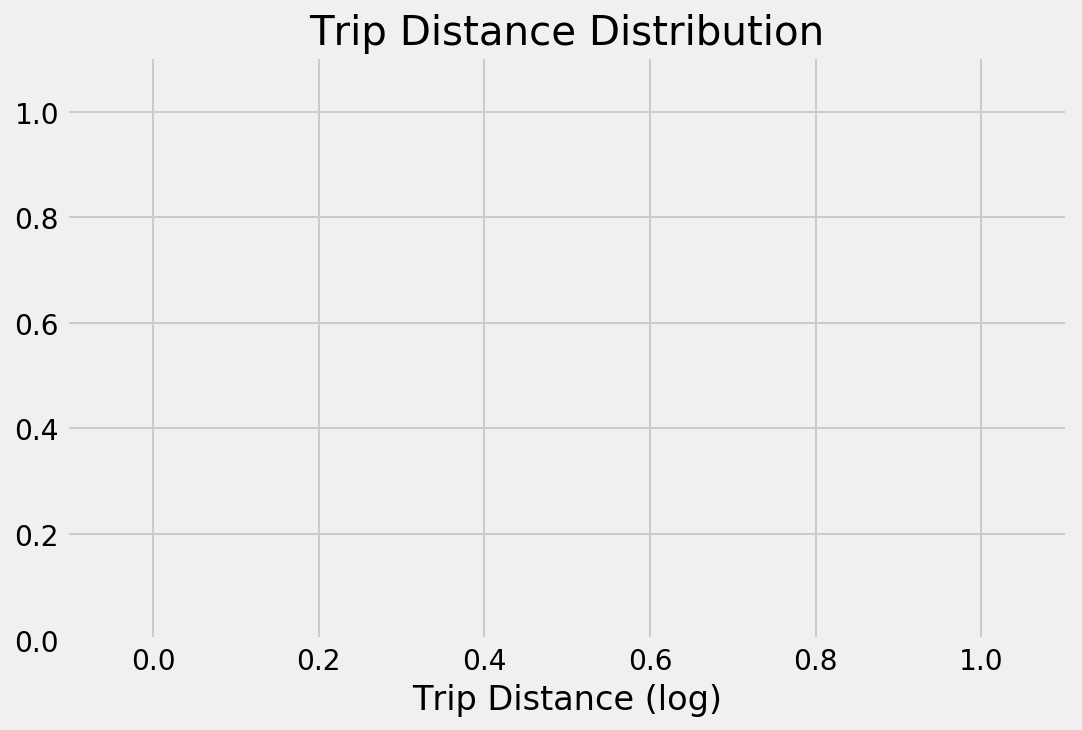

In [66]:
plt.figure(figsize=(8, 5))
sns.kdeplot(np.log(
    train['trip_distance'].values)).set_title("Trip Distance Distribution")
plt.xlabel("Trip Distance (log)")

Text(0, 0.5, 'Trip Duration (log scale)')

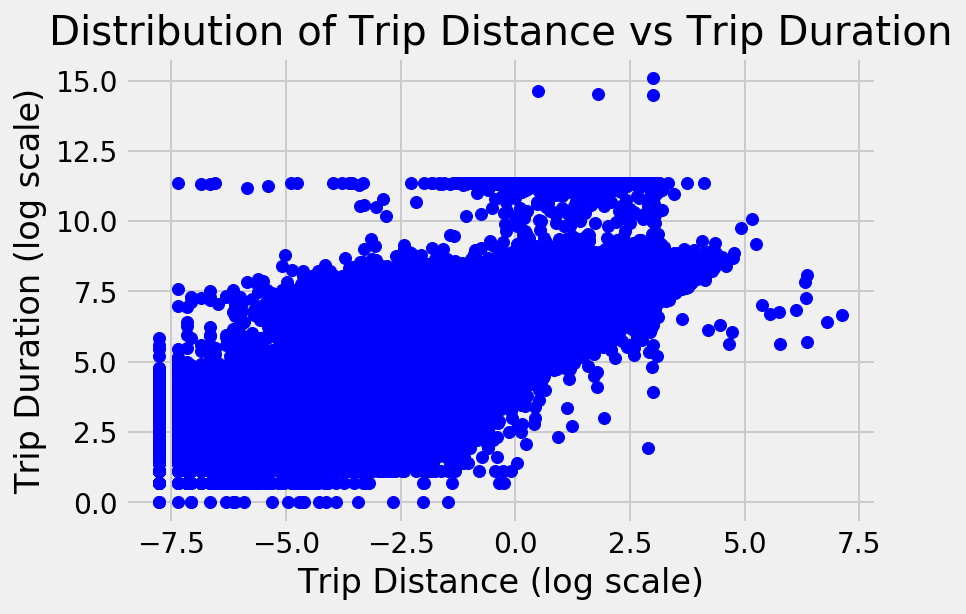

In [67]:
plt.scatter(np.log(train['trip_distance'].values),
            np.log(train['trip_duration'].values),
            color='blue',
            label='train')
plt.title("Distribution of Trip Distance vs Trip Duration")
plt.xlabel("Trip Distance (log scale)")
plt.ylabel("Trip Duration (log scale)")

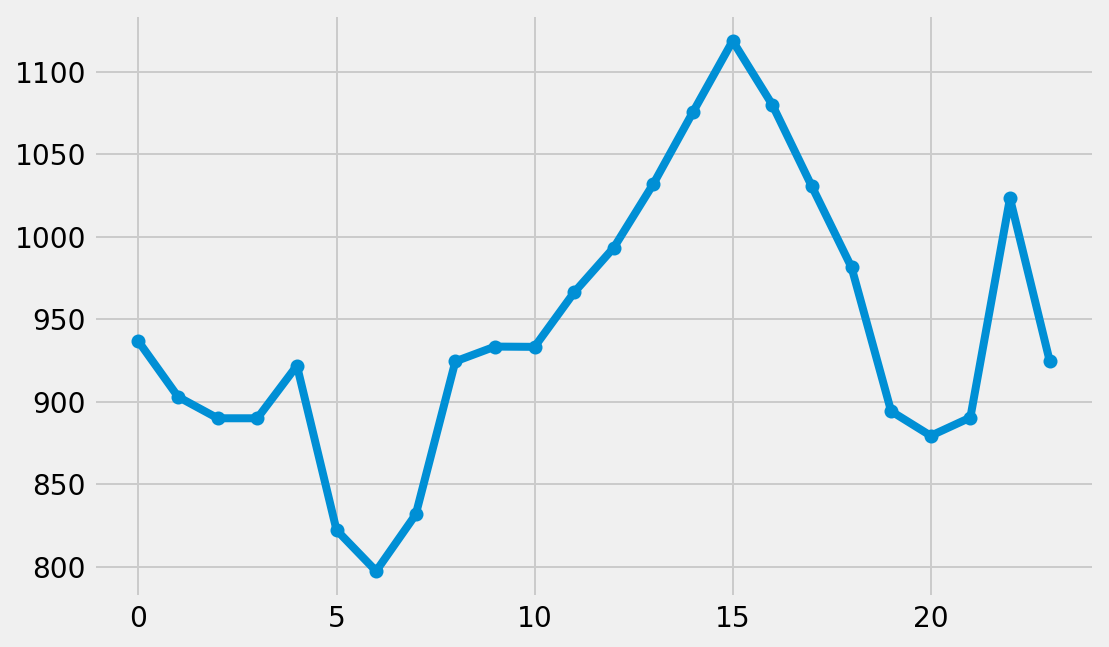

In [68]:
avg_duration_hour = train.groupby(
    ['pickup_hour'])['trip_duration'].mean().reset_index().rename(
        columns={'trip_duration': 'avg_trip_duration'})
plt.figure(figsize=(8, 5))
plt.plot(train.groupby(['pickup_hour'])['trip_duration'].mean(), 'o-')

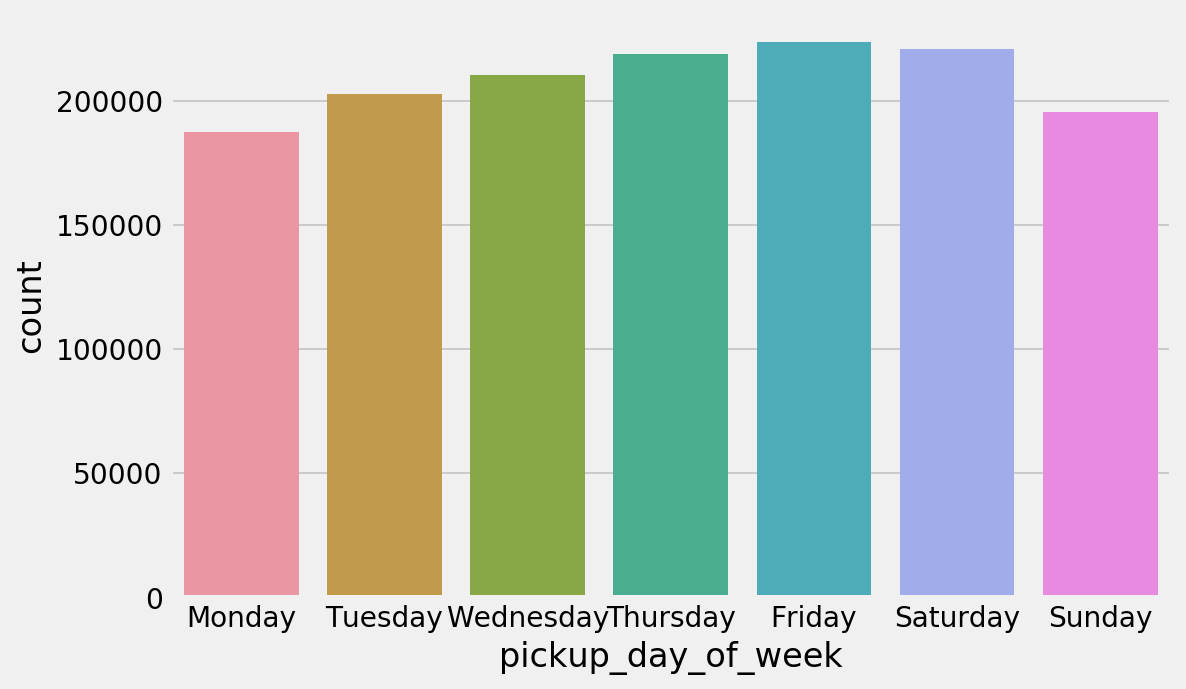

In [69]:
plt.figure(figsize=(8, 5))
sns.countplot(train['pickup_day_of_week'],
              order=[
                  'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                  'Saturday', 'Sunday'
              ])

In [70]:
avg_duration_day = train.groupby(
    ['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(
        columns={'trip_duration': 'avg_trip_duration'})

Text(0.5, 1.0, 'Avg Trip Duration vs Pickup Days of Week')

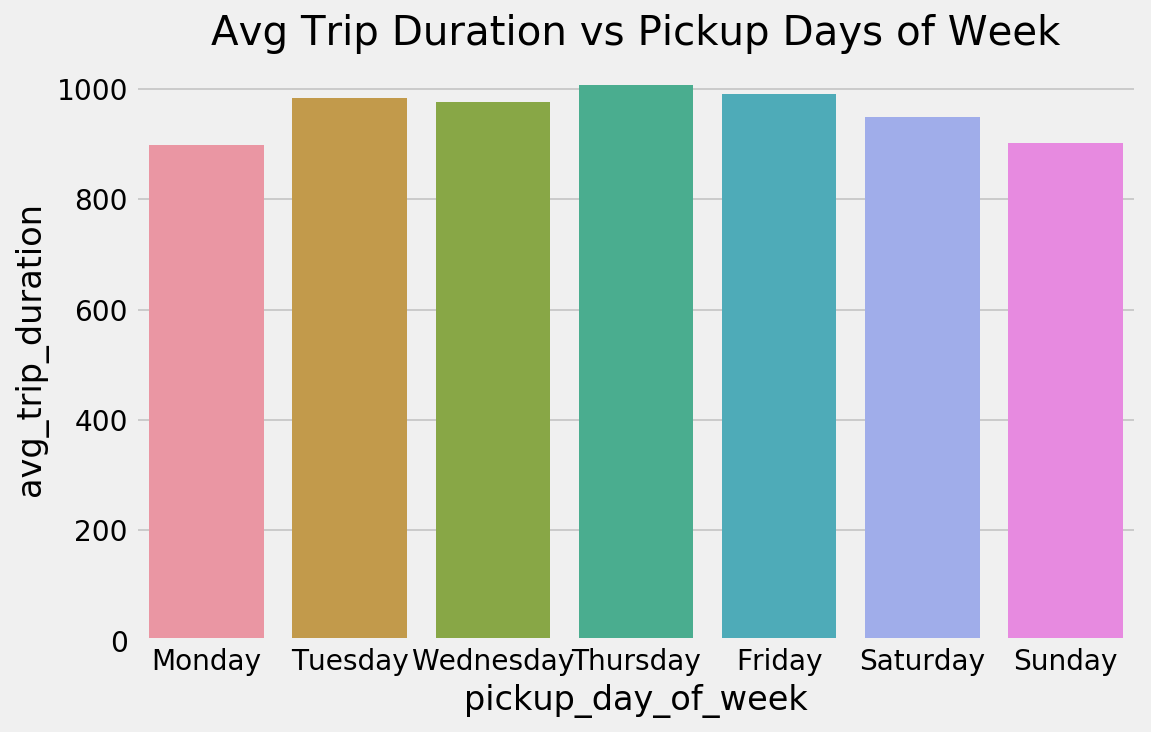

In [71]:
plt.figure(figsize=(8, 5))
sns.barplot(x='pickup_day_of_week',
            y='avg_trip_duration',
            data=avg_duration_day,
            order=[
                'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                'Saturday', 'Sunday'
            ]).set_title("Avg Trip Duration vs Pickup Days of Week")